# Road Safety Dataset

### by Bernardo Augusto and Miguel Cisneiros

In [1]:
# Imports
from pyspark import SparkFiles

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px



from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from sklearn import metrics
from sklearn.metrics import classification_report 


import findspark
findspark.init()
import pyspark # Call this only after findspark.init()
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [2]:
# Load the data
dataset = spark.read.csv("file://"+ SparkFiles.get("/Users/bernardoaugusto/Desktop/3º ano/1º semestre/Big Data/Project/2/Road Safety Data - Accidents 2019.csv"),header=True, sep=",", inferSchema=True)

#show top 10 rows
dataset.show(10) 

+--------------+---------------------+----------------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-----+--------------------------+-------------------------+--------------+---------------+---------+-----------+---------------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+
|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude| Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|Road_Type|Speed_limit|Junction_Detail|Junction_Control|2nd_Road_Class|2nd_Road_Number|Pedestrian_Crossing-Human_

In [3]:
# Schema
dataset.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: integer (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: integer (nullable = true)
 |-- Junction_Control: integer (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-

In [4]:
# convert the dataset to pandas dataset for the explanatory analysis
dataset_pd = dataset.toPandas()

In [5]:
# Variable Types
dataset_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               117536 non-null  object 
 1   Location_Easting_OSGR                        117508 non-null  float64
 2   Location_Northing_OSGR                       117508 non-null  float64
 3   Longitude                                    117508 non-null  float64
 4   Latitude                                     117508 non-null  float64
 5   Police_Force                                 117536 non-null  int32  
 6   Accident_Severity                            117536 non-null  int32  
 7   Number_of_Vehicles                           117536 non-null  int32  
 8   Number_of_Casualties                         117536 non-null  int32  
 9   Date                                         117536 non-nul

In [6]:
# Shape of the Dataset
dataset_pd.shape

(117536, 32)

In [7]:
# dataset shown as a pandas dataset for easier visualization (only shows the top 5 rows)
dataset_pd.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0,5,1,1,1,0,0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,-1,-1,4,1,1,0,0,1,3,E01003117
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000943
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000973
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000546


# Data Cleaning

In [8]:
# discover how many data is missing
missing = dataset_pd.isnull().sum()

print(missing)

Accident_Index                                    0
Location_Easting_OSGR                            28
Location_Northing_OSGR                           28
Longitude                                        28
Latitude                                         28
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                             63
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

In [9]:
# drop all the rows that have null values
dataset_pd = dataset_pd.dropna()

In [10]:
# we shall drop the Accident_Index and LSOA_of_Accident_Location collumn
# because these collumns will not be relevant for the exploratory analysis
dataset_pd = dataset_pd.drop(['Accident_Index', 'LSOA_of_Accident_Location'], axis=1)

In [11]:
# discover how many data is missing
missing = dataset_pd.isnull().sum()

print(missing)

Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                               0
2nd_Road_Class                                 0
2nd_Road_Number     

In [12]:
# removes the -1 value that is a mistake on the dataset 

# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Light_Conditions'] != -1]

In [13]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Junction_Control'] != -1]

In [14]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['2nd_Road_Class'] != -1]

In [15]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Pedestrian_Crossing-Human_Control'] != -1]

In [16]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Pedestrian_Crossing-Physical_Facilities'] != -1]

In [17]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Road_Surface_Conditions'] != -1]

In [18]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Special_Conditions_at_Site'] != -1]

In [19]:
# Get indexes where column has value -1
dataset_pd = dataset_pd[dataset_pd['Carriageway_Hazards'] != -1]

In [20]:
# Drop the -1 values from the spark dataset
dataset = dataset.filter((dataset["Light_Conditions"] != -1) & (dataset["Junction_Control"] != -1) & (dataset["2nd_Road_Class"] != -1)
                        & (dataset["Pedestrian_Crossing-Human_Control"] != -1) & (dataset["Pedestrian_Crossing-Physical_Facilities"] != -1)
                        & (dataset["Road_Surface_COnditions"] != -1) & (dataset["Special_Conditions_at_Site"] != -1)
                        & (dataset["Carriageway_Hazards"] != -1)
                        )

In [21]:
dataset_pd.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
0,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,2,...,4202,0,5,1,1,1,0,0,1,3
2,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,3,...,0,0,0,4,1,1,0,0,1,1
3,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,01/01/2019,3,...,510,0,0,4,1,1,0,0,1,1
4,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,01/01/2019,3,...,0,0,0,4,1,1,0,0,1,1
6,532424.0,164886.0,-0.099071,51.367605,1,3,1,1,01/01/2019,3,...,271,0,5,4,1,1,0,0,1,1


In [22]:
dataset.na.drop("all")

DataFrame[Accident_Index: string, Location_Easting_OSGR: int, Location_Northing_OSGR: int, Longitude: double, Latitude: double, Police_Force: int, Accident_Severity: int, Number_of_Vehicles: int, Number_of_Casualties: int, Date: string, Day_of_Week: int, Time: string, Local_Authority_(District): int, Local_Authority_(Highway): string, 1st_Road_Class: int, 1st_Road_Number: int, Road_Type: int, Speed_limit: int, Junction_Detail: int, Junction_Control: int, 2nd_Road_Class: int, 2nd_Road_Number: int, Pedestrian_Crossing-Human_Control: int, Pedestrian_Crossing-Physical_Facilities: int, Light_Conditions: int, Weather_Conditions: int, Road_Surface_Conditions: int, Special_Conditions_at_Site: int, Carriageway_Hazards: int, Urban_or_Rural_Area: int, Did_Police_Officer_Attend_Scene_of_Accident: int, LSOA_of_Accident_Location: string]

In [23]:
from pyspark.sql.functions import isnan, when, count, col
dataset.select([count(when(isnan(c), c)).alias(c) for c in dataset.columns]).show()

+--------------+---------------------+----------------------+---------+--------+------------+-----------------+------------------+--------------------+----+-----------+----+--------------------------+-------------------------+--------------+---------------+---------+-----------+---------------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+
|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude|Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Date|Day_of_Week|Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|Road_Type|Speed_limit|Junction_Detail|Junction_Control|2nd_Road_Class|2nd_Road_Number|Pedestrian_Crossing-Human_Control|Pedestri

In [24]:
# there is no more null or -1 values so lets move to the explanatory analysis

In [25]:
# maybe normalize the date and location, longitude and latitude for better analysis of the data

# Exploratory Data Analysis

In [26]:
# Metrics
dataset_pd.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,...,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.000000,59932.00000
mean,459218.912351,259799.832961,-1.142866,52.226561,23.588717,2.789979,1.870920,1.289945,4.113879,283.629030,...,554.012130,0.032921,1.204532,1.958019,1.549740,1.299323,0.067343,0.037075,1.234266,1.30276
std,86165.621288,119555.794891,1.247277,1.079194,19.760418,0.429927,0.608509,0.709593,1.905283,221.892736,...,1517.548589,0.246111,2.225858,1.581333,1.620071,0.511362,0.536035,0.384053,0.423542,0.54470
min,135706.000000,20568.000000,-5.695002,50.042087,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000
25%,397654.000000,175284.500000,-2.035581,51.464290,4.000000,3.000000,2.000000,1.000000,3.000000,70.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000
50%,462786.000000,207007.000000,-1.077103,51.752274,20.000000,3.000000,2.000000,1.000000,4.000000,286.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000
75%,529005.000000,363975.250000,-0.140848,53.167372,43.000000,3.000000,2.000000,1.000000,6.000000,480.000000,...,52.000000,0.000000,1.000000,4.000000,1.000000,2.000000,0.000000,0.000000,1.000000,2.00000
max,655244.000000,656369.000000,1.757476,55.800599,63.000000,3.000000,13.000000,25.000000,7.000000,753.000000,...,9899.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.000000,7.000000,2.000000,3.00000


In [27]:
# show the number of accidents by severity in the dataset
dataset_pd['Accident_Severity'].value_counts()

3    47912
2    11453
1      567
Name: Accident_Severity, dtype: int64

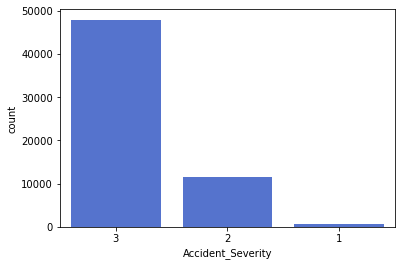

In [28]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Accident_Severity',data=dataset_pd, color="royalblue", order = dataset_pd['Accident_Severity'].value_counts().index)

In [29]:
# show the distribution of roads according to the light conditions in the dataset, to determine which is more prospect to accidents
dataset_pd['Light_Conditions'].value_counts()

1    42795
4    14431
6     1295
7     1002
5      409
Name: Light_Conditions, dtype: int64

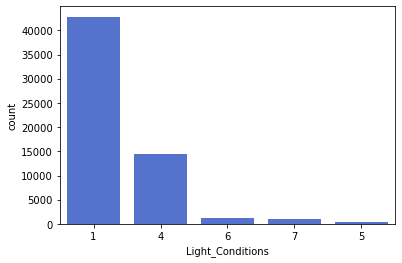

In [30]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Light_Conditions',data=dataset_pd, color="royalblue", order = dataset_pd['Light_Conditions'].value_counts().index)

In [31]:
# set the day of the week to names instead of numbers
dataset_pd["Day_of_Week"].replace({1: "Sun", 2: "Mon", 3: "Tue", 4: "Wed", 5: "Thu", 6: "Fri", 7: "Sat"}, inplace=True)

In [32]:
dataset_pd.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
0,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,Mon,...,4202,0,5,1,1,1,0,0,1,3
2,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,Tue,...,0,0,0,4,1,1,0,0,1,1
3,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,01/01/2019,Tue,...,510,0,0,4,1,1,0,0,1,1
4,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,01/01/2019,Tue,...,0,0,0,4,1,1,0,0,1,1
6,532424.0,164886.0,-0.099071,51.367605,1,3,1,1,01/01/2019,Tue,...,271,0,5,4,1,1,0,0,1,1


In [33]:
# show the distribution of roads according to the light conditions in the dataset, to determine which is more prospect to accidents
dataset_pd['Day_of_Week'].value_counts()

Fri    9765
Thu    9197
Wed    9181
Tue    9160
Mon    8549
Sat    7766
Sun    6314
Name: Day_of_Week, dtype: int64

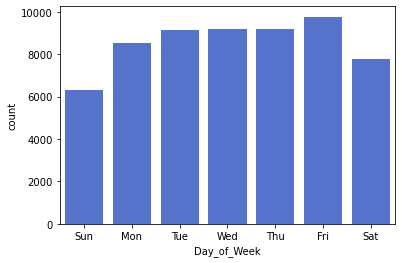

In [34]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Day_of_Week',data=dataset_pd, color="royalblue", order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])

In [35]:
# show the distribution of roads according to the light conditions in the dataset, to determine which is more prospect to accidents
dataset_pd['Road_Surface_Conditions'].value_counts()

1    43029
2    16352
4      425
3       96
5       30
Name: Road_Surface_Conditions, dtype: int64

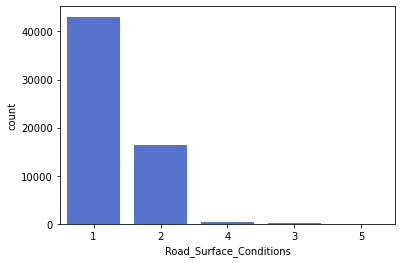

In [36]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Road_Surface_Conditions',data=dataset_pd, color="royalblue", order = dataset_pd['Road_Surface_Conditions'].value_counts().index)

In [37]:
# show the distribution of roads according to the light conditions in the dataset, to determine which is more prospect to accidents
dataset_pd['Weather_Conditions'].value_counts()

1    47895
2     7873
8     1423
9     1179
4      622
5      613
7      169
3      147
6       11
Name: Weather_Conditions, dtype: int64

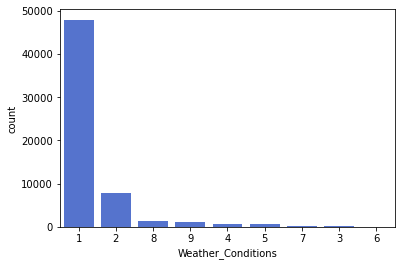

In [38]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Weather_Conditions',data=dataset_pd, color="royalblue", order = dataset_pd['Weather_Conditions'].value_counts().index)

In [39]:
# show the distribution of roads according to the light conditions in the dataset, to determine which is more prospect to accidents
dataset_pd['Number_of_Casualties'].value_counts()

1     47897
2      8584
3      2267
4       777
5       266
6        85
7        30
8        11
9         4
10        3
19        2
12        2
25        1
20        1
13        1
11        1
Name: Number_of_Casualties, dtype: int64

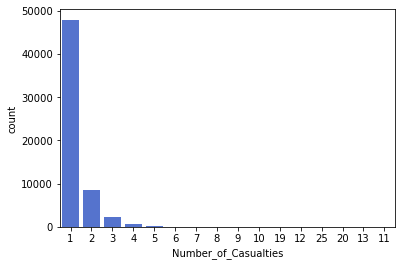

In [40]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Number_of_Casualties',data=dataset_pd, color="royalblue", order = dataset_pd['Number_of_Casualties'].value_counts().index)

In [41]:
# show the distribution of roads according to the light conditions in the dataset, to determine which is more prospect to accidents
dataset_pd['Number_of_Vehicles'].value_counts()

2     41540
1     13680
3      3817
4       680
5       144
6        41
7        18
8         8
9         2
13        1
10        1
Name: Number_of_Vehicles, dtype: int64

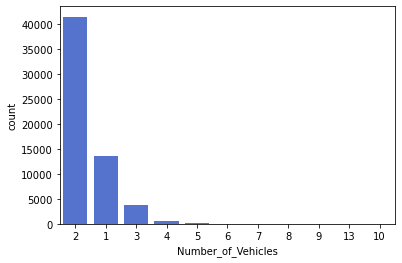

In [42]:
# graph of the number of accidents by severity in the dataset, to determine which is more regular as result of accidents
sns.countplot(x='Number_of_Vehicles',data=dataset_pd, color="royalblue", order = dataset_pd['Number_of_Vehicles'].value_counts().index)

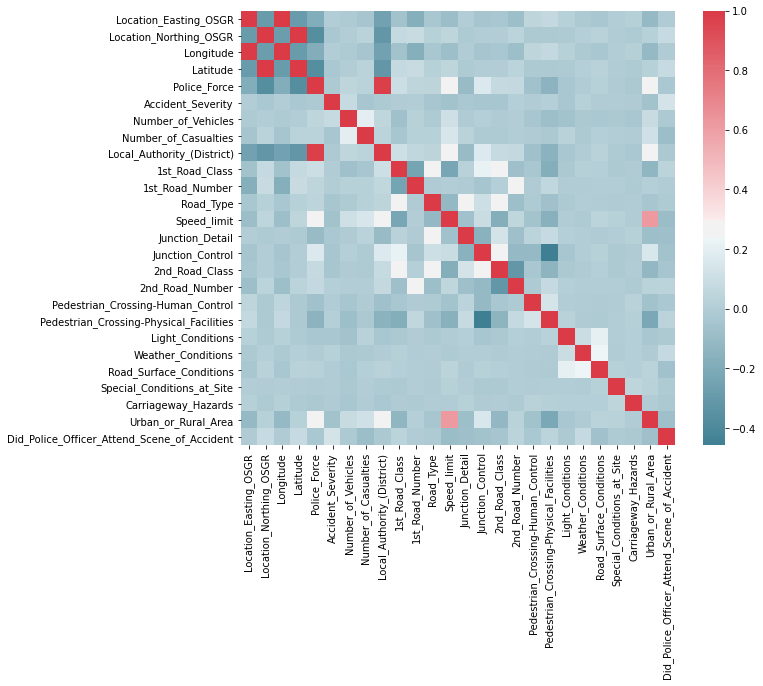

In [43]:
# heatmap to show the relational between features
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset_pd.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [44]:
# we can drop 1 of the more correlated variables because we just need 1 of them 
# For example, the Latitde is extremely correlated to the Location_Northing_OSGR and so we can drop one of them
# I would probably drop the Location_Northing_OSGR because with the latitude i could probably use for geographic analysis (the other one too but its harder)

In [45]:
dataset_pd = dataset_pd.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Police_Force'], axis=1)

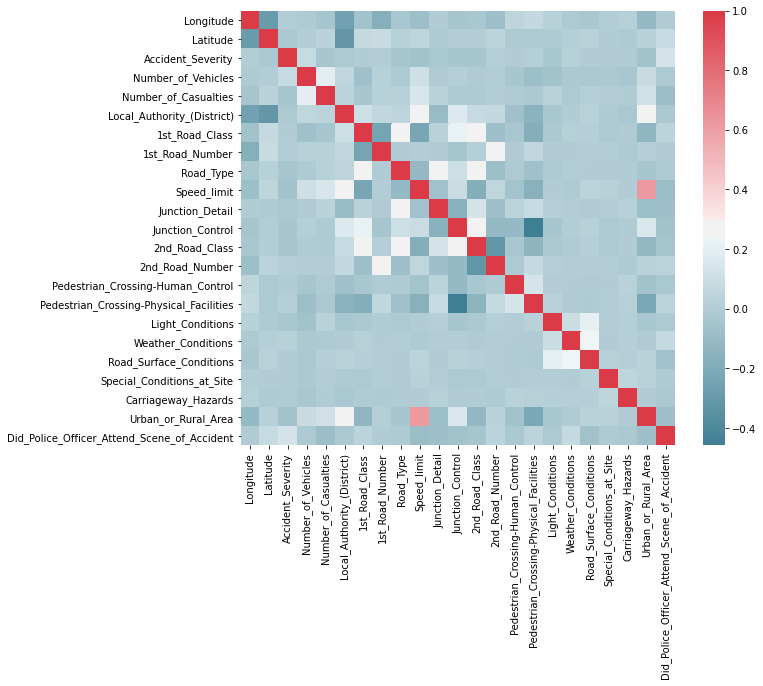

In [46]:
# heatmap to show the relational between features
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset_pd.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [47]:
# There is a bit of correlation between speed limit and urban or rural area but these 
# two aren't as correlated as the ones mentioned previously